In [10]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm

In [25]:
def estimate_epc(G: nx.Graph, N: int) -> float:
  """Estimate the expected path count (EPC) for a given graph G and number of paths N.
  Args:
    G (nx.Graph): The input graph.
    N (int): The number of paths to consider.
  Returns:
    float: The estimated expected path count.
  """
  n = G.number_of_nodes()
  nodes = list(G.nodes())
  C2 = 0.0
  for _ in tqdm(range(N), desc="Estimating EPC", total=N):
    # Randomly select a starting node and perform a random walk
    u = np.random.choice(nodes)
    visited = {u}
    queue = [u]
    while queue:
      v = queue.pop(0)
      for w in G.neighbors(v):
        if w not in visited and np.random.rand() < G.edges[v, w]['p']:
          visited.add(w)
          queue.append(w)
    C2 += (len(visited) - 1)  # Exclude the starting node
  return (n * C2) / (2 * N)

In [12]:
def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
    """Remove the top-k nodes by betweenness centrality."""
    bc = nx.betweenness_centrality(G)
    top_k = sorted(bc, key=bc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(top_k)
    return H

In [13]:

def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
    """Remove the top-k edges by PageRank on the line graph."""
    L = nx.line_graph(G)
    pr = nx.pagerank(L, alpha=0.85)
    top_k = sorted(pr, key=pr.get, reverse=True)[:k]
    H = G.copy()
    H.remove_edges_from(top_k)
    return H

In [16]:
# --- Sanity checks for Algorithm 2 ---

MC_SAMPLES = 100000
# 1) p = 0 on any graph => EPC ≈ 0
G0 = nx.erdos_renyi_graph(10, 20, seed=1)
for u, v in G0.edges():
    G0.edges[u, v]['p'] = 0.0
print("Empty-graph test (p=0):", estimate_epc(G0, N=MC_SAMPLES), "≈ 0")

# 2) p = 1 on complete graph => EPC ≈ n(n-1)/2
n = 200
G1 = nx.complete_graph(n)
for u, v in tqdm(G1.edges(), desc="Setting p=1 on complete graph", total=G1.number_of_edges()):
    G1.edges[u, v]['p'] = 1.0
print("Complete-graph test (p=1):", estimate_epc(G1, N=MC_SAMPLES), "≈", n*(n-1)/2)

Empty-graph test (p=0): 0.0 ≈ 0


Setting p=1 on complete graph: 100%|██████████| 19900/19900 [00:00<00:00, 2383875.98it/s]

Complete-graph test (p=1): 19900.0 ≈ 19900.0


In [19]:
# 3) Small-graph exact enumeration vs estimator

def exact_epc_enumeration(G: nx.Graph, p: float) -> float:
    """Compute exact EPC by enumerating all 2^m subgraphs (m small)."""
    m = G.number_of_edges()
    edges = list(G.edges())
    total = 0.0
    for mask in tqdm(range(1 << m), desc="Enumerating subgraphs", total=(1 << m)):
        prob = 1.0
        H = nx.Graph()
        H.add_nodes_from(G.nodes())
        for i, e in enumerate(edges):
            if (mask >> i) & 1:
                prob *= p
                H.add_edge(*e)
            else:
                prob *= (1 - p)
        comp_sizes = [len(c) for c in nx.connected_components(H)]
        total += prob * sum(s*(s-1)//2 for s in comp_sizes)
    return total

In [28]:
N = 100
G_small = nx.path_graph(N)  # 4 nodes, 3 edges => 2^3=8 subgraphs

# Parameters
n_nodes = 10
n_edges = 20
p_edge = 0.5  # or any other fixed probability for all edges

# Generate Erdős–Rényi G(n, m) graph
G_er = nx.gnm_random_graph(n=n_nodes, m=n_edges, seed=42)

for p in np.arange(0.0, 1.1, 0.1):
    for u, v in G_er.edges():
        G_er.edges[u, v]['p'] = p

    est = estimate_epc(G_er, N=100000)

    exact = exact_epc_enumeration(G_er, p)
    print(f"Small-graph (n={N}, p={p}) → estimator={est:.3f}, exact={exact:.3f}")

Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 71533.33it/s]


Small-graph (n=100, p=0.0) → estimator=0.000, exact=0.000


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 72647.04it/s]


Small-graph (n=100, p=0.1) → estimator=2.872, exact=2.869


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 73587.93it/s]


Small-graph (n=100, p=0.2) → estimator=8.197, exact=8.175


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 71188.15it/s]


Small-graph (n=100, p=0.30000000000000004) → estimator=16.167, exact=16.163


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 72617.44it/s]


Small-graph (n=100, p=0.4) → estimator=25.384, exact=25.394


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 72226.62it/s]


Small-graph (n=100, p=0.5) → estimator=33.595, exact=33.577


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 72881.65it/s]


Small-graph (n=100, p=0.6000000000000001) → estimator=39.281, exact=39.269


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 73279.82it/s]


Small-graph (n=100, p=0.7000000000000001) → estimator=42.534, exact=42.507


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 73994.59it/s]


Small-graph (n=100, p=0.8) → estimator=44.085, exact=44.105


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 72152.68it/s]


Small-graph (n=100, p=0.9) → estimator=44.804, exact=44.806


Enumerating subgraphs: 100%|██████████| 1048576/1048576 [00:14<00:00, 72981.73it/s]

Small-graph (n=100, p=1.0) → estimator=45.000, exact=45.000


In [30]:
# --- Replication loop for k=5, N_eval=1e5 (can lower N for quick tests) ---

models = {
    'ER': nx.erdos_renyi_graph(100, 200, seed=42),
    'BA': nx.barabasi_albert_graph(100, 2, seed=42),
    'SW': nx.watts_strogatz_graph(100, 4, 0.3, seed=42),
    # 'US': load_your_us_backbone(),  # replace with real topology
}

ps = np.arange(0.1, 1.1, 0.1)
k = 10
N_eval = int(1e5)  # use 1e3 for quick sanity runs

records = []
for name, G0 in tqdm(models.items(), desc="Processing models", total=len(models)):
    for p in ps:
        G = G0.copy()
        for u, v in G.edges():
            G.edges[u, v]['p'] = p
        G_bc = remove_k_betweenness(G, k)
        G_pr = remove_k_pagerank_edges(G, k)
        epc_bc = estimate_epc(G_bc, N=N_eval)
        epc_pr = estimate_epc(G_pr, N=N_eval)

        records.append(
            {
              'model': name, 
              'p': p, 
              'EPC_bc': epc_bc, 
              'EPC_pr': epc_pr,
             })

df = pd.DataFrame(records)

Estimating EPC: 100%|██████████| 100000/100000 [00:06<00:00, 15158.63it/s]


ModuleNotFoundError: No module named 'ace_tools'

In [31]:
df

,model,p,EPC_bc,EPC_pr
0,ER,0.1,22.854150,30.4840
1,ER,0.2,79.377250,123.7910
2,ER,0.3,267.386525,542.2590
3,ER,0.4,888.959175,1818.2595
4,ER,0.5,1950.763725,3145.5885
5,ER,0.6,2861.964300,3911.3995
6,ER,0.7,3444.763175,4358.2820
7,ER,0.8,3789.569000,4611.8990
8,ER,0.9,4023.634750,4763.6780
9,ER,1.0,4184.741925,4849.5790


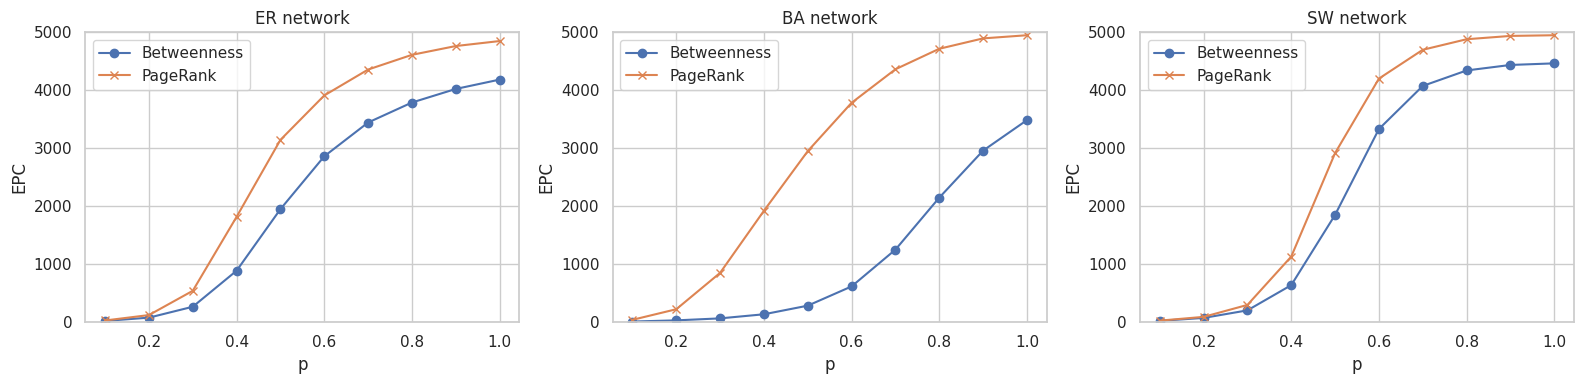

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(16, 4))

for i, model in enumerate(df['model'].unique()):
    plt.subplot(1, 3, i+1)
    subset = df[df['model'] == model]
    plt.plot(subset['p'], subset['EPC_bc'], marker='o', label='Betweenness')
    plt.plot(subset['p'], subset['EPC_pr'], marker='x', label='PageRank')
    plt.title(f"{model} network")
    plt.xlabel("p")
    plt.ylabel("EPC")
    plt.ylim(0, 5000)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [37]:
import networkx as nx
import numpy as np
import random

def sample_realization(G: nx.Graph) -> nx.Graph:
    """
    Generate one deterministic realization of the probabilistic graph G.
    Each edge (u,v) is kept with probability G.edges[u,v]['p'].
    """
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if random.random() < G.edges[u, v]['p']:
            H.add_edge(u, v)
    return H

def pairwise_connectivity(H: nx.Graph) -> float:
    """
    Compute the pairwise connectivity of H:
    sum_{C in connected_components} |C|*(|C|-1)/2
    """
    return sum(len(c)*(len(c)-1)/2 for c in nx.connected_components(H))

def sample_average_objective(G: nx.Graph, removal_set: set, T: int) -> float:
    """
    Estimate the expected pairwise connectivity after removing nodes in removal_set,
    by sampling T realizations and averaging their connectivity.
    """
    total = 0.0
    for _ in range(T):
        H = sample_realization(G)
        H.remove_nodes_from(removal_set)
        total += pairwise_connectivity(H)
    return total / T

def greedy_initial_SAA(G: nx.Graph, k: int, T: int) -> set:
    """
    Greedy initialization for SAA: at each step pick the node whose removal
    most reduces the sample-average connectivity on T realizations.
    """
    S = set()
    candidates = set(G.nodes())
    for _ in range(k):
        best_node, best_obj = None, float('inf')
        for u in candidates:
            obj = sample_average_objective(G, S | {u}, T)
            if obj < best_obj:
                best_node, best_obj = u, obj
        S.add(best_node)
        candidates.remove(best_node)
    return S

def SAA(G: nx.Graph, k: int, T: int) -> set:
    """
    Sample Average Approximation with local search (as in REGA).
    1) Greedy initialize removal set S of size k
    2) Repeatedly attempt 1-for-1 swaps that improve the sample-average objective.
    """
    # 1) Greedy start
    S = greedy_initial_SAA(G, k, T)
    improved = True
    while improved:
        improved = False
        current_obj = sample_average_objective(G, S, T)
        for u in tqdm(list(S), desc="Local search iterations", total=len(S)):
            for v in set(G.nodes()) - S:
                newS = (S - {u}) | {v}
                new_obj = sample_average_objective(G, newS, T)
                if new_obj < current_obj:
                    S, improved = newS, True
                    current_obj = new_obj
                    break
            if improved:
                break
    return S

# --- Demonstration on a small ER graph ---
G_test = nx.erdos_renyi_graph(100, 200, seed=123)

for u,v in G_test.edges():
    G_test.edges[u, v]['p'] = 0.5

k = 5
T = 30  # number of samples for SAA (as in paper) fileciteturn5file3
removal_set = SAA(G_test, k, T)
print("SAA removal set:", removal_set)
print("Sample-average EPC:", sample_average_objective(G_test, removal_set, T))


Local search iterations: 100%|██████████| 5/5 [00:33<00:00,  6.66s/it]

SAA removal set: {0, 1, 2, 3, 4}
Sample-average EPC: 4465.0


Processing models: 100%|██████████| 3/3 [10:55<00:00, 218.35s/it]


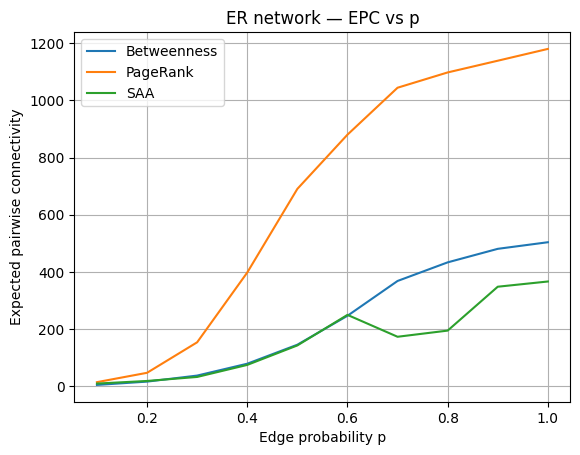

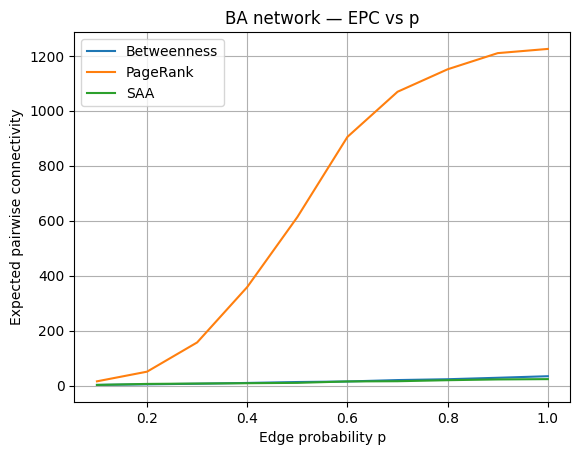

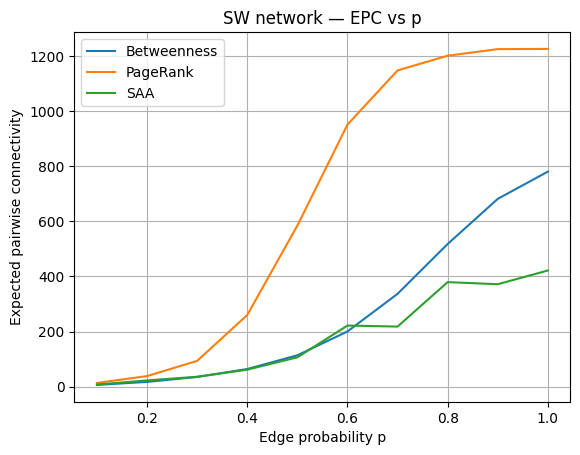

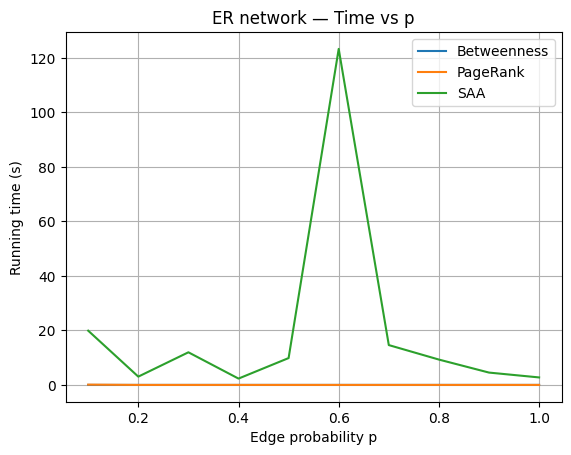

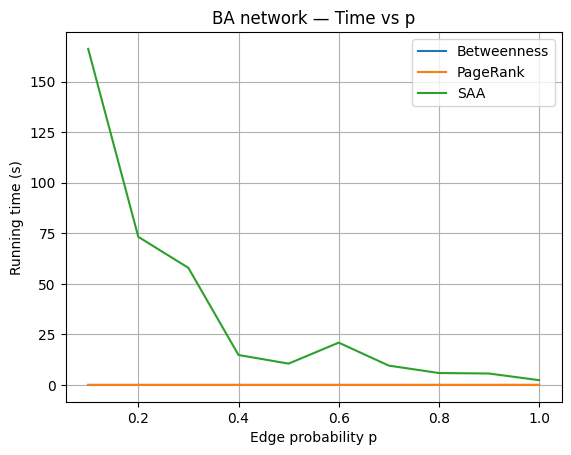

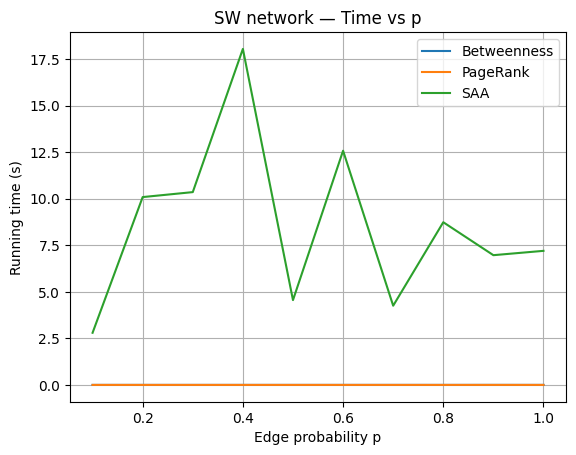

In [ ]:
import networkx as nx
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# ----- Core Algorithms -----
def sample_realization(G: nx.Graph) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if random.random() < G.edges[u, v]['p']:
            H.add_edge(u, v)
    return H

def pairwise_connectivity(H: nx.Graph) -> float:
    return sum(len(c) * (len(c) - 1) / 2 for c in nx.connected_components(H))

def estimate_epc(G: nx.Graph, N: int) -> float:
    n = G.number_of_nodes()
    total = 0.0
    for _ in range(N):
        u = random.choice(list(G.nodes()))
        visited = {u}
        queue = [u]
        while queue:
            v = queue.pop(0)
            for w in G.neighbors(v):
                if w not in visited and random.random() < G.edges[v, w]['p']:
                    visited.add(w)
                    queue.append(w)
        total += (len(visited) - 1)
    return (n * total) / (2 * N)

def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
    bc = nx.betweenness_centrality(G)
    topk = sorted(bc, key=bc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
    L = nx.line_graph(G)
    pr = nx.pagerank(L)
    topr = sorted(pr, key=pr.get, reverse=True)[:k]
    H = G.copy()
    H.remove_edges_from(topr)
    return H

def sample_average_objective(G: nx.Graph, S: set, T: int) -> float:
    total = 0.0
    for _ in range(T):
        H = sample_realization(G)
        H.remove_nodes_from(S)
        total += pairwise_connectivity(H)
    return total / T

def greedy_initial_SAA(G: nx.Graph, k: int, T: int) -> set:
    S = set()
    candidates = set(G.nodes())
    for _ in range(k):
        best_node, best_obj = None, float('inf')
        for u in candidates:
            obj = sample_average_objective(G, S | {u}, T)
            if obj < best_obj:
                best_node, best_obj = u, obj
        S.add(best_node)
        candidates.remove(best_node)
    return S

def SAA(G: nx.Graph, k: int, T: int) -> set:
    S = greedy_initial_SAA(G, k, T)
    improved = True
    while improved:
        improved = False
        current_obj = sample_average_objective(G, S, T)
        for u in list(S):
            for v in set(G.nodes()) - S:
                newS = (S - {u}) | {v}
                new_obj = sample_average_objective(G, newS, T)
                if new_obj < current_obj:
                    S, improved, current_obj = newS, True, new_obj
                    break
            if improved:
                break
    return S

# ----- Experiment Runner -----
def run_experiments(
        models: dict, ps: np.ndarray, k: int, 
        T_saa: int, N_eval: int) -> pd.DataFrame:
    
    records = []
    for name, G0 in tqdm(models.items(), desc="Processing models", total=len(models)):

        for p in tqdm(ps, desc=f"Processing p values for {name}", total=len(ps)):
            G = G0.copy()
            for u, v in G.edges():
                G.edges[u, v]['p'] = p

            # Betweenness
            start = time.perf_counter()
            G_bc = remove_k_betweenness(G, k)
            t_bc = time.perf_counter() - start
            epc_bc = estimate_epc(G_bc, N_eval)

            # PageRank
            start = time.perf_counter()
            G_pr = remove_k_pagerank_edges(G, k)
            t_pr = time.perf_counter() - start
            epc_pr = estimate_epc(G_pr, N_eval)

            # SAA
            start = time.perf_counter()
            S_saa = SAA(G, k, T_saa)
            G_saa = G.copy()
            G_saa.remove_nodes_from(S_saa)
            t_saa = time.perf_counter() - start
            epc_saa = estimate_epc(G_saa, N_eval)

            records.extend([
                {'model': name, 'p': p, 'algo': 'Betweenness', 'time': t_bc, 'epc': epc_bc},
                {'model': name, 'p': p, 'algo': 'PageRank',    'time': t_pr, 'epc': epc_pr},
                {'model': name, 'p': p, 'algo': 'SAA',         'time': t_saa, 'epc': epc_saa},
            ])
    return pd.DataFrame(records)

# ----- Define Topologies -----
models = {
    'ER': nx.gnm_random_graph(50, 100, seed=42),
    'BA': nx.barabasi_albert_graph(50, 2, seed=42),
    'SW': nx.watts_strogatz_graph(50, 4, 0.3, seed=42),
    # 'US': nx.read_edgelist('us_backbone.edgelist'),  # uncomment and adjust path
}

ps = np.arange(0.0, 1.2, 0.2)
k = 15
T_saa = 30
N_eval = 10000   # for quick testing; set to 100000 for publication-quality EPC

# Run and collect
df = run_experiments(models, ps, k, T_saa, N_eval)

# Preview the results
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Replication Data Preview", dataframe=df.head(15))

# ----- Plotting Figures 2 & 3 -----
# EPC vs p (Fig. 2)
for model in models:
    plt.figure()
    subset = df[df.model == model]
    for algo in ['Betweenness', 'PageRank', 'SAA']:
        data = subset[subset.algo == algo]
        plt.plot(data.p, data.epc, label=algo)
    plt.xlabel('Edge probability p')
    plt.ylabel('Expected pairwise connectivity')
    plt.title(f'{model} network — EPC vs p')
    plt.legend()
    plt.grid(True)

# Time vs p (Fig. 3)
for model in models:
    plt.figure()
    subset = df[df.model == model]
    for algo in ['Betweenness', 'PageRank', 'SAA']:
        data = subset[subset.algo == algo]
        plt.plot(data.p, data.time, label=algo)
    plt.xlabel('Edge probability p')
    plt.ylabel('Running time (s)')
    plt.title(f'{model} network — Time vs p')
    plt.legend()
    plt.grid(True)

plt.show()


Processing models: 100%|██████████| 3/3 [12:15<00:00, 245.08s/it]


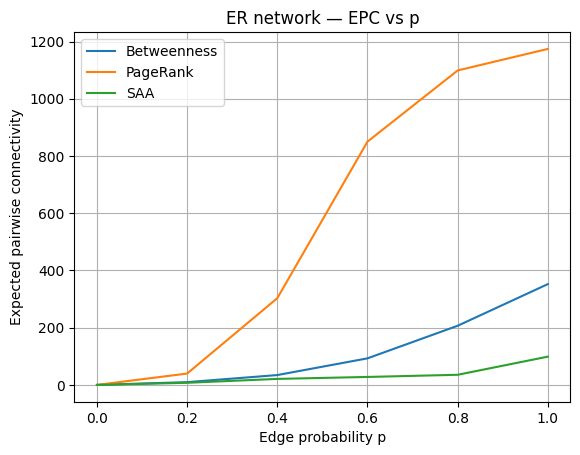

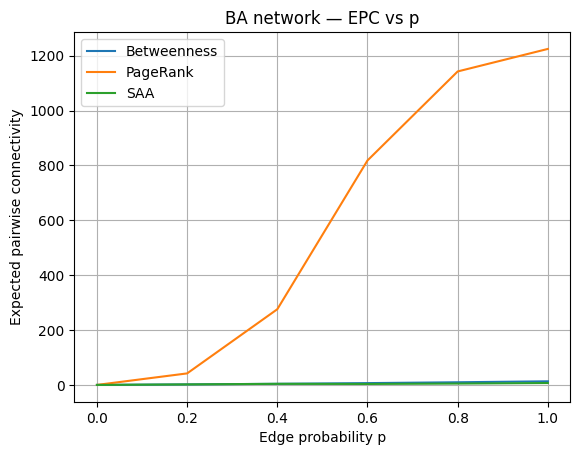

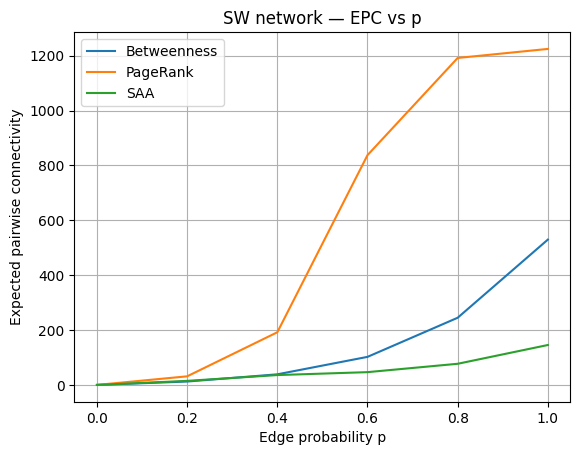

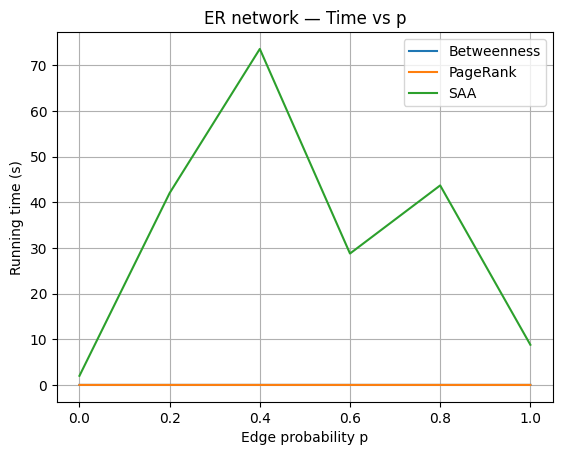

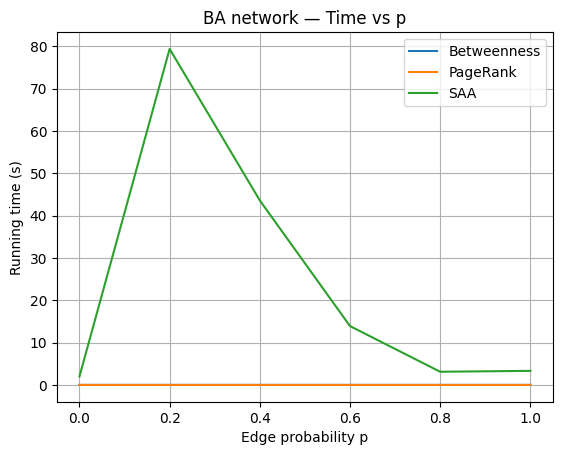

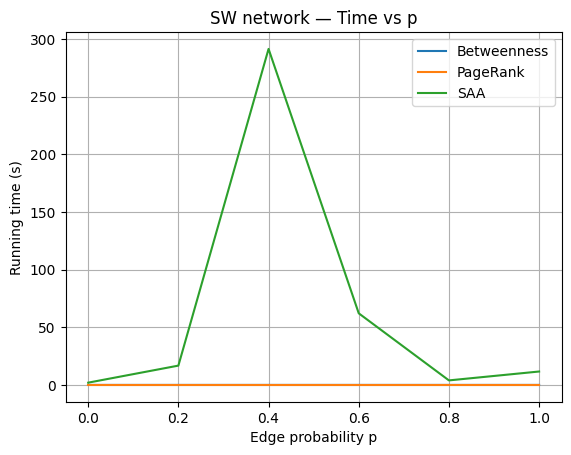

In [3]:
import networkx as nx
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# ----- Core Algorithms -----
def sample_realization(G: nx.Graph) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if random.random() < G.edges[u, v]['p']:
            H.add_edge(u, v)
    return H

def pairwise_connectivity(H: nx.Graph) -> float:
    return sum(len(c) * (len(c) - 1) / 2 for c in nx.connected_components(H))

def estimate_epc(G: nx.Graph, N: int) -> float:
    n = G.number_of_nodes()
    total = 0.0
    for _ in range(N):
        u = random.choice(list(G.nodes()))
        visited = {u}
        queue = [u]
        while queue:
            v = queue.pop(0)
            for w in G.neighbors(v):
                if w not in visited and random.random() < G.edges[v, w]['p']:
                    visited.add(w)
                    queue.append(w)
        total += (len(visited) - 1)
    return (n * total) / (2 * N)

def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
    bc = nx.betweenness_centrality(G)
    topk = sorted(bc, key=bc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
    L = nx.line_graph(G)
    pr = nx.pagerank(L)
    topr = sorted(pr, key=pr.get, reverse=True)[:k]
    H = G.copy()
    H.remove_edges_from(topr)
    return H

def sample_average_objective(G: nx.Graph, S: set, T: int) -> float:
    total = 0.0
    for _ in range(T):
        H = sample_realization(G)
        H.remove_nodes_from(S)
        total += pairwise_connectivity(H)
    return total / T

def greedy_initial_SAA(G: nx.Graph, k: int, T: int) -> set:
    S = set()
    candidates = set(G.nodes())
    for _ in range(k):
        best_node, best_obj = None, float('inf')
        for u in candidates:
            obj = sample_average_objective(G, S | {u}, T)
            if obj < best_obj:
                best_node, best_obj = u, obj
        S.add(best_node)
        candidates.remove(best_node)
    return S

def SAA(G: nx.Graph, k: int, T: int) -> set:
    S = greedy_initial_SAA(G, k, T)
    improved = True
    while improved:
        improved = False
        current_obj = sample_average_objective(G, S, T)
        for u in list(S):
            for v in set(G.nodes()) - S:
                newS = (S - {u}) | {v}
                new_obj = sample_average_objective(G, newS, T)
                if new_obj < current_obj:
                    S, improved, current_obj = newS, True, new_obj
                    break
            if improved:
                break
    return S

# ----- Experiment Runner -----
def run_experiments(
        models: dict, ps: np.ndarray, k: int, 
        T_saa: int, N_eval: int) -> pd.DataFrame:
    
    records = []
    for name, G0 in tqdm(models.items(), desc="Processing models", total=len(models)):

        for p in tqdm(ps, desc=f"Processing p values for {name}", total=len(ps)):
            G = G0.copy()
            for u, v in G.edges():
                G.edges[u, v]['p'] = p

            # Betweenness
            start = time.perf_counter()
            G_bc = remove_k_betweenness(G, k)
            t_bc = time.perf_counter() - start
            epc_bc = estimate_epc(G_bc, N_eval)

            # PageRank
            start = time.perf_counter()
            G_pr = remove_k_pagerank_edges(G, k)
            t_pr = time.perf_counter() - start
            epc_pr = estimate_epc(G_pr, N_eval)

            # SAA
            start = time.perf_counter()
            S_saa = SAA(G, k, T_saa)
            G_saa = G.copy()
            G_saa.remove_nodes_from(S_saa)
            t_saa = time.perf_counter() - start
            epc_saa = estimate_epc(G_saa, N_eval)

            records.extend([
                {'model': name, 'p': p, 'algo': 'Betweenness', 'time': t_bc, 'epc': epc_bc},
                {'model': name, 'p': p, 'algo': 'PageRank',    'time': t_pr, 'epc': epc_pr},
                {'model': name, 'p': p, 'algo': 'SAA',         'time': t_saa, 'epc': epc_saa},
            ])
    return pd.DataFrame(records)

# ----- Define Topologies -----
models = {
    'ER': nx.gnm_random_graph(50, 100, seed=42),
    'BA': nx.barabasi_albert_graph(50, 2, seed=42),
    'SW': nx.watts_strogatz_graph(50, 4, 0.3, seed=42),
    # 'US': nx.read_edgelist('us_backbone.edgelist'),  # uncomment and adjust path
}

ps = np.arange(0.0, 1.2, 0.2)
k = 15
T_saa = 30
N_eval = 10000   # for quick testing; set to 100000 for publication-quality EPC

# Run and collect
df = run_experiments(models, ps, k, T_saa, N_eval)

# Preview the results
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Replication Data Preview", dataframe=df.head(15))

# ----- Plotting Figures 2 & 3 -----
# EPC vs p (Fig. 2)
for model in models:
    plt.figure()
    subset = df[df.model == model]
    for algo in ['Betweenness', 'PageRank', 'SAA']:
        data = subset[subset.algo == algo]
        plt.plot(data.p, data.epc, label=algo)
    plt.xlabel('Edge probability p')
    plt.ylabel('Expected pairwise connectivity')
    plt.title(f'{model} network — EPC vs p')
    plt.legend()
    plt.grid(True)

# Time vs p (Fig. 3)
for model in models:
    plt.figure()
    subset = df[df.model == model]
    for algo in ['Betweenness', 'PageRank', 'SAA']:
        data = subset[subset.algo == algo]
        plt.plot(data.p, data.time, label=algo)
    plt.xlabel('Edge probability p')
    plt.ylabel('Running time (s)')
    plt.title(f'{model} network — Time vs p')
    plt.legend()
    plt.grid(True)

plt.show()


In [4]:
import networkx as nx
import numpy as np
import random
import pandas as pd

# 1) Prepare test set with n=50, m=100 edges
models = {}

# Erdos-Renyi (exactly 100 edges)
models['ER'] = nx.gnm_random_graph(50, 100, seed=1)

# Barabasi-Albert (start with BA, then add random edges to reach 100)
G_ba = nx.barabasi_albert_graph(50, 2, seed=1)
while G_ba.number_of_edges() < 100:
    u, v = random.sample(G_ba.nodes(), 2)
    if not G_ba.has_edge(u, v):
        G_ba.add_edge(u, v)
models['BA'] = G_ba

# Watts-Strogatz (k=4 yields exactly 100 edges)
models['SW'] = nx.watts_strogatz_graph(50, 4, 0.1, seed=1)

ps = [0.1, 0.3, 0.6, 1.0]
K = 10           # removal budget
N_samples = 10000  # MC samples for EPC estimation

# Reuse EPC estimator (Algorithm 2 from earlier)
def estimate_epc(G, N):
    n = G.number_of_nodes()
    total = 0
    for _ in range(N):
        # Sample a connected component by BFS from random node
        u = random.choice(list(G.nodes()))
        visited = {u}
        queue = [u]
        while queue:
            v = queue.pop(0)
            for w in G.neighbors(v):
                if w not in visited and random.random() < G.edges[v, w]['p']:
                    visited.add(w)
                    queue.append(w)
        total += (len(visited) - 1)
    return (n * total) / (2 * N)

def estimate_epc_subgraph(G, S, N):
    H = G.copy()
    H.remove_nodes_from(S)
    return estimate_epc(H, N)

# 2) Implement Algorithm 2 (Greedy CNDP)
def greedy_cn_dp(G, k, N):
    S = set()
    # initial EPC
    sigma_S = estimate_epc_subgraph(G, S, N)
    for _ in range(k):
        best_v = None
        best_drop = -1
        best_obj = sigma_S
        # try removing each candidate
        for v in set(G.nodes()) - S:
            obj = estimate_epc_subgraph(G, S | {v}, N)
            drop = sigma_S - obj
            if drop > best_drop:
                best_drop = drop
                best_v = v
                best_obj = obj
        S.add(best_v)
        sigma_S = best_obj
    return S, sigma_S

# Run sanity check for each model and p
records = []
for name, G0 in tqdm(models.items(), desc="Processing models", total=len(models)):
    for p in ps:
        G = G0.copy()
        # assign uniform probability p
        for u, v in G.edges():
            G.edges[u, v]['p'] = p
        S, epc = greedy_cn_dp(G, K, N_samples)
        records.append({
            'model': name,
            'p': p,
            'removal_set': S,
            'estimated_EPC': round(epc, 2)
        })

df = pd.DataFrame(records)

/tmp/ipykernel_420102/1580205083.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u, v = random.sample(G_ba.nodes(), 2)
Processing models: 100%|██████████| 3/3 [07:06<00:00, 142.07s/it]


In [5]:
df

,model,p,removal_set,estimated_EPC
0,ER,0.1,"{32, 1, 33, 35, 11, 14, 48, 17, 18, 24}",4.96
1,ER,0.3,"{32, 1, 35, 39, 11, 14, 48, 17, 18, 49}",21.84
2,ER,0.6,"{32, 1, 35, 39, 11, 14, 48, 18, 24, 30}",101.48
3,ER,1.0,"{0, 35, 6, 39, 41, 43, 47, 27, 30, 31}",493.83
4,BA,0.1,"{0, 32, 33, 3, 5, 6, 8, 12, 22, 25}",2.65
5,BA,0.3,"{0, 33, 3, 5, 6, 8, 12, 16, 22, 25}",9.17
6,BA,0.6,"{0, 33, 3, 5, 6, 8, 12, 16, 22, 25}",23.40
7,BA,1.0,"{0, 33, 3, 5, 6, 8, 12, 17, 22, 25}",50.03
8,SW,0.1,"{2, 40, 43, 13, 14, 47, 17, 24, 28, 30}",7.38
9,SW,0.3,"{2, 36, 8, 41, 42, 14, 47, 22, 27, 30}",29.48


In [ ]:
import networkx as nx
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# ----- Core Sampling & EPC Estimation -----
def sample_realization(G):
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if random.random() < G.edges[u, v]['p']:
            H.add_edge(u, v)
    return H

def pairwise_connectivity(H):
    return sum(len(c)*(len(c)-1)/2 for c in nx.connected_components(H))

def estimate_epc(G, N):
    n = G.number_of_nodes()
    total = 0.0
    for _ in range(N):
        u = random.choice(list(G.nodes()))
        visited, queue = {u}, [u]
        while queue:
            v = queue.pop(0)
            for w in G.neighbors(v):
                if w not in visited and random.random() < G.edges[v,w]['p']:
                    visited.add(w); queue.append(w)
        total += (len(visited)-1)
    return (n * total) / (2 * N)

# ----- Betweenness & PageRank Heuristics -----
def remove_k_betweenness(G, k):
    bc = nx.betweenness_centrality(G)
    topk = sorted(bc, key=bc.get, reverse=True)[:k]
    H = G.copy(); H.remove_nodes_from(topk); return H

def remove_k_pagerank_edges(G, k):
    L = nx.line_graph(G)
    pr = nx.pagerank(L, alpha=0.85)
    topr = sorted(pr, key=pr.get, reverse=True)[:k]
    H = G.copy(); H.remove_edges_from(topr); return H

# ----- Sample Average Approximation (SAA) -----
def greedy_initial_SAA(G, k, T):
    S = set(); candidates=set(G.nodes())
    for _ in range(k):
        best, best_obj = None, float('inf')
        for u in candidates:
            H=G.copy(); H.remove_nodes_from(S|{u})
            obj=estimate_epc(H, T)
            if obj<best_obj: best, best_obj=u, obj
        S.add(best); candidates.remove(best)
    return S

def SAA(G, k, T):
    S = greedy_initial_SAA(G, k, T)
    improved=True
    while improved:
        improved=False
        curr_obj = estimate_epc(G.copy().remove_nodes_from(S) or G, T)
        for u in list(S):
            for v in set(G.nodes())-S:
                newS=(S-{u})|{v}
                H=G.copy(); H.remove_nodes_from(newS)
                obj=estimate_epc(H, T)
                if obj<curr_obj:
                    S, improved, curr_obj=newS, True, obj
                    break
            if improved: break
    return S

# ----- LP-Relaxation & REGA -----
def solve_lp_relaxation(G, D, k):
    nodes=list(G.nodes()); n=len(nodes)
    edges=list(G.edges()); m=len(edges)
    idx_s={nodes[i]:i for i in range(n)}
    idx_z={(u,v):n+j for j,(u,v) in enumerate(edges)}
    bounds=[(0,1)]*(n+m)
    for u in D: bounds[idx_s[u]]=(1,1)
    # sum s_i = k
    A_eq = np.zeros((1,n+m)); b_eq=[k]
    for u in nodes: A_eq[0,idx_s[u]]=1
    # linearization constraints
    A_ub, b_ub = [], []
    for (u,v) in edges:
        iu,iv,iz=idx_s[u], idx_s[v], idx_z[(u,v)]
        # z <= 1 - s_u
        row=np.zeros(n+m); row[iu]=1; row[iz]=1
        A_ub.append(row); b_ub.append(1)
        # z <= 1 - s_v
        row=np.zeros(n+m); row[iv]=1; row[iz]=1
        A_ub.append(row); b_ub.append(1)
        # z >= 1 - s_u - s_v  => -z - s_u - s_v <= -1
        row=np.zeros(n+m); row[iz]=-1; row[iu]=-1; row[iv]=-1
        A_ub.append(row); b_ub.append(-1)
    c = np.zeros(n+m)
    for j,(u,v) in enumerate(edges): c[n+j]=G.edges[u,v]['p']
    res = linprog(c, A_ub=np.array(A_ub), b_ub=np.array(b_ub),
                  A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    if not res.success: raise RuntimeError("LP infeasible")
    return {nodes[i]:float(res.x[idx_s[nodes[i]]]) for i in range(n)}

def REGA_with_LP(G, k, T, R, alpha):
    def sample_avg(S):
        H=G.copy(); H.remove_nodes_from(S)
        return estimate_epc(H, T)
    best_S,best_obj=None,float('inf'); nodes=set(G.nodes())
    for _ in range(R):
        D=set()
        # greedy build via LP-rnd
        for _ in range(k):
            s_vals=solve_lp_relaxation(G, D, k)
            rem=list(nodes-D)
            sorted_nodes=sorted(rem, key=lambda u:s_vals[u], reverse=True)
            pool=sorted_nodes[:max(1,int(alpha*len(sorted_nodes)))]
            D.add(random.choice(pool))
        # local swaps
        curr=sample_avg(D)
        improved=True
        while improved:
            improved=False
            for u in list(D):
                for v in nodes-D:
                    newS=(D-{u})|{v}
                    val=sample_avg(newS)
                    if val<curr:
                        D, curr, improved=newS, val, True
                        break
                if improved: break
        if curr<best_obj: best_obj, best_S=curr, D.copy()
    return best_S

# ----- Prepare test set -----
models = {
    'ER': nx.gnm_random_graph(50, 100, seed=1),
    'BA': (lambda G=nx.barabasi_albert_graph(50,2,seed=1):
           (G if G.number_of_edges()>=100 else G).copy())(),
    'SW': nx.watts_strogatz_graph(50, 4, 0.3, seed=1)
}
# Ensure BA has 100 edges
while models['BA'].number_of_edges()<100:
    u,v = random.sample(list(models['BA'].nodes()),2)
    if not models['BA'].has_edge(u,v): models['BA'].add_edge(u,v)

ps=[0.1,0.3,0.6,1.0]

K=10
T_saa=30
T_rega=1000   # local search samples
R_rega=5
alpha=0.3
N_eval=10000   # EPC eval samples

# ----- Run comparisons -----
records=[]
for name,G0 in tqdm(models.items(), desc="Processing models", total=len(models)):
    for p in tqdm(ps, desc=f"Processing p values for {name}", total=len(ps)):
        G=G0.copy()
        for u,v in G.edges(): G.edges[u,v]['p']=p

        # Betweenness
        t0=time.perf_counter()
        H_bc=remove_k_betweenness(G, K)
        t_bc=time.perf_counter()-t0
        epc_bc=estimate_epc(H_bc, N_eval)

        # PageRank
        t0=time.perf_counter()
        H_pr=remove_k_pagerank_edges(G, K)
        t_pr=time.perf_counter()-t0
        epc_pr=estimate_epc(H_pr, N_eval)

        # SAA
        t0=time.perf_counter()
        S_saa=SAA(G, K, T_saa)
        H_saa=G.copy(); H_saa.remove_nodes_from(S_saa)
        t_saa=time.perf_counter()-t0
        epc_saa=estimate_epc(H_saa, N_eval)

        # REGA
        t0=time.perf_counter()
        S_rega=REGA_with_LP(G, K, T_rega, R_rega, alpha)
        H_rega=G.copy(); H_rega.remove_nodes_from(S_rega)
        t_rega=time.perf_counter()-t0
        epc_rega=estimate_epc(H_rega, N_eval)

        for algo,t,epc in [
            ('Betweenness', t_bc, epc_bc),
            ('PageRank',    t_pr, epc_pr),
            ('SAA',         t_saa, epc_saa),
            ('REGA',        t_rega, epc_rega)
        ]:
            records.append({'model':name,'p':p,'algo':algo,
                            'time':t,'epc':epc})

# ----- Plot EPC vs p for each model & algo -----
for name in models:
    plt.figure()
    for algo in df.algo.unique():
        sub=df[(df.model==name)&(df.algo==algo)]
        plt.plot(sub.p, sub.epc, marker='o', label=algo)
    plt.title(f"{name} — EPC vs p")
    plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()

    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.time, label=algo)
    plt.title(f"{name} — Time vs p")
    plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
    plt.savefig(f"{name}_time_vs_p.png")


plt.show()


Processing models:   0%|          | 0/3 [00:00<?, ?it/s]